c:\Users\arodr\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\arodr\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\Users\arodr\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


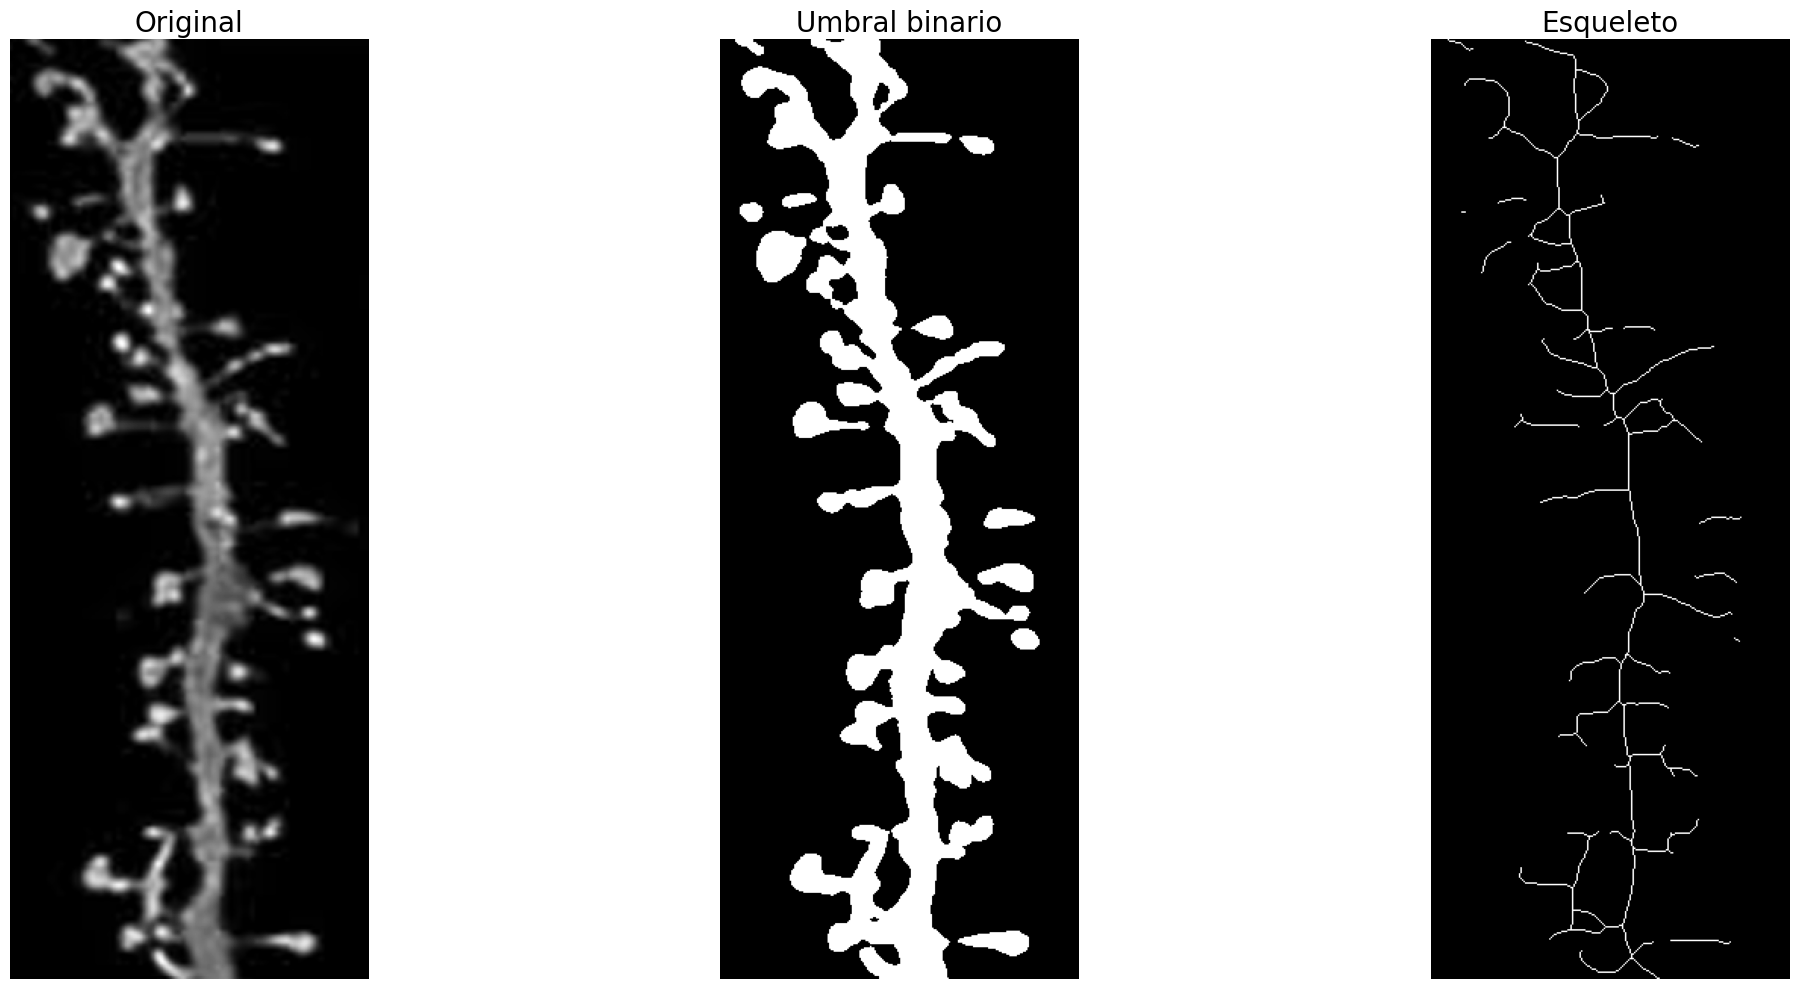

In [1]:
import cv2
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize

# Cargamos la imagen
image = cv2.imread('epina.png', cv2.IMREAD_GRAYSCALE)

# Aplicamos un suavizado gaussiano (Este paso nos ayuda sobre todo a evitar la aparición de ruido en los bordes)
blurred = cv2.GaussianBlur(image, (5, 5), 0)

# Aplicamos un umbral global o threshold (este número representa la luminosidad mínima que tiene que tener un píxel para ser incluído en la máscara binaria)
umbral = 30
_, binary = cv2.threshold(image, umbral, 255, cv2.THRESH_BINARY)

# Convertimos la imagen binaria a un booleano (píxeles blancos/negros = true/false)
binary_bool = binary == 255

# Aplicamos skeletonize para crear un esqueleto a partir de la binarización de la imágen original
skeleton = skeletonize(binary_bool)

# Mostramos los resultados

plt.figure(figsize=(24, 10))  # Aumentamos el tamaño

# mostramos la imagen original
plt.subplot(1, 3, 1)
plt.title("Original", fontsize=20)
plt.imshow(image, cmap='gray')
plt.axis('off')

# mostramos la imagen binarizada
plt.subplot(1, 3, 2)
plt.title("Umbral binario", fontsize=20)
plt.imshow(binary, cmap='gray')
plt.axis('off')

# mostramos el esqueleto obtenido como resultado
plt.subplot(1, 3, 3)
plt.title("Esqueleto", fontsize=20)
plt.imshow(skeleton, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

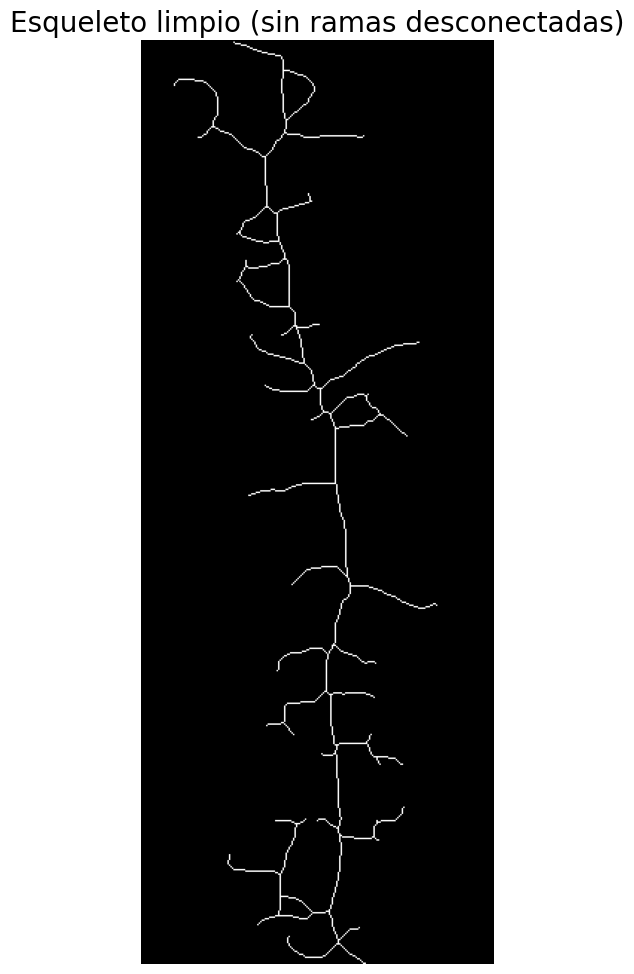

In [2]:
from skimage.measure import label, regionprops

# Etiquetamos los fragmentos conexos del esqueleto
labeled = label(skeleton)

# Calculamos las regiones conectadas del esqueleto
regions = regionprops(labeled)

# Ordenamos las regiones que hemos sacado del esqueleto en función de su área (la más grande por lo general suele ser el tallo dendrítico)
regions.sort(key=lambda r: r.area, reverse=True)

# Creamos una nueva etiqueta solamente para el tallo
main_label = regions[0].label

# Creamos un esqueleto nuevo y limpio que solamente contenga el tallo
skeleton_clean = (labeled == main_label)

# Mostramos el resultado

plt.figure(figsize=(16, 12))
plt.imshow(skeleton_clean, cmap='gray')
plt.title("Esqueleto limpio (sin ramas desconectadas)", fontsize=20)
plt.axis('off')
plt.show()


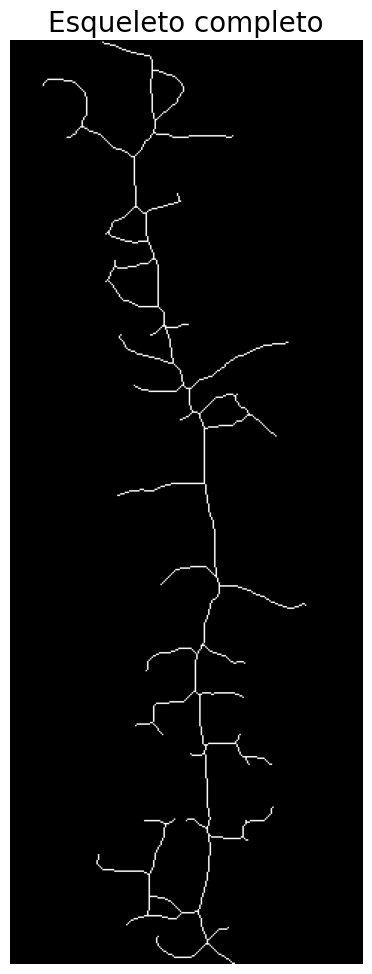

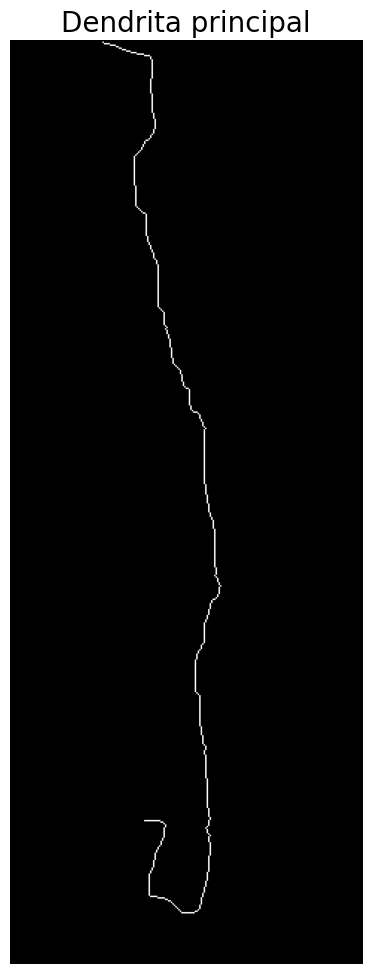

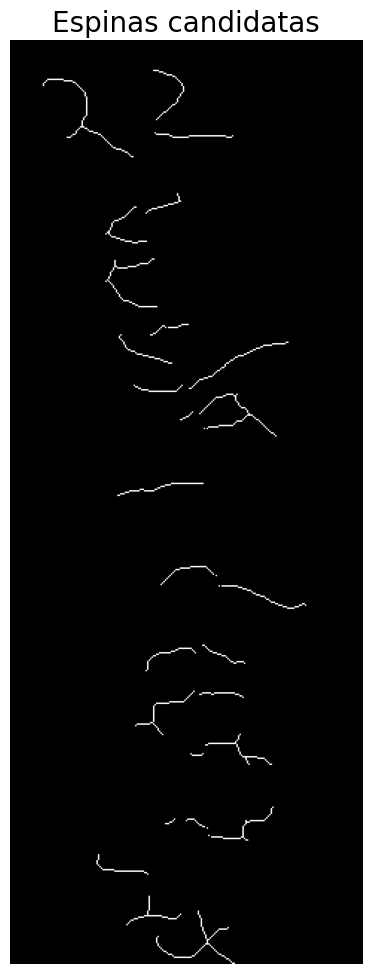

In [3]:
import numpy as np
from scipy.ndimage import convolve
from skimage.graph import route_through_array
from skimage.util import invert


# Detectamos los puntos que son extremos (los extremos solamente deberían tener 1 vecino)
neighbor_count = convolve(skeleton_clean.astype(np.uint8), np.ones((3, 3)), mode='constant', cval=0)
endpoints = (skeleton_clean & (neighbor_count == 2))  # 1 vecino + sí mismo = 2

# sacamos las coordenadas de los supuestos extremos
end_coords = np.column_stack(np.where(endpoints))

# buscamos la ruta más larga que exista de entre los extremos
max_dist = 0
main_path_coords = []

for i in range(len(end_coords)):
    for j in range(i + 1, len(end_coords)):
        start = tuple(end_coords[i])
        end = tuple(end_coords[j])
        try:
            path, cost = route_through_array(invert(skeleton_clean).astype(np.uint8), start, end, fully_connected=True)
            if len(path) > max_dist:
                max_dist = len(path)
                main_path_coords = path
        except:
            continue

# Creamos la máscara del tallo dendrítico (por lo general debería ser la ruta más larga dentro del esqueleto)
main_mask = np.zeros_like(skeleton_clean, dtype=bool)
for y, x in main_path_coords:
    main_mask[y, x] = True

# Las espinas candidatas son lo que nos queda como resultado cuando le restamos la máscara del tallo dendrítico al esqueleto limpio
possible_spines = skeleton_clean & ~main_mask

# Mostramos los resultados en imagenes
plt.figure(figsize=(16, 12))
plt.imshow(skeleton_clean, cmap='gray')
plt.title("Esqueleto completo", fontsize=20)
plt.axis('off')
plt.show()

plt.figure(figsize=(16, 12))
plt.imshow(main_mask, cmap='gray')
plt.title("Dendrita principal", fontsize=20)
plt.axis('off')
plt.show()

plt.figure(figsize=(16, 12))
plt.imshow(possible_spines, cmap='gray')
plt.title("Espinas candidatas", fontsize=20)
plt.axis('off')
plt.show()


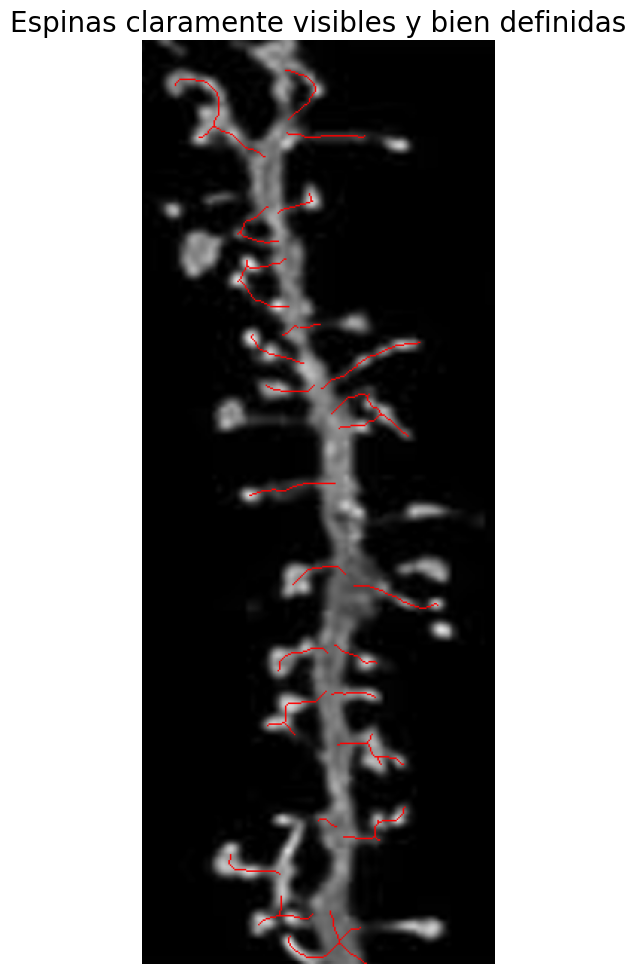

Espinas claras encontradas: 25


In [4]:
# Etiquetamos las espinas candidatas
espinas_label = label(possible_spines)

# Creamos una imagen vacía que nos servirá para guardar solamente las espinas claras posteriormente
espinas_claras = np.zeros_like(possible_spines, dtype=bool)

# Establecemos unos filtros determinados para la detección de espinas

min_area = 10  # descarta supuestas espinas que sean demasiado pequeñas
max_area = 150 # descarta supuestas espinas que sean extremadamente grandes

# Evaluamos cada una de las espinas detectadas
for region in regionprops(espinas_label):
    area = region.area
    if area < min_area or area > max_area:
        continue

    # Si pasa los filtros conservaremos la espina
    coords = region.coords
    for y, x in coords:
        espinas_claras[y, x] = True

# Mostramos las espinas claras sobre la fotografía original
overlay = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
overlay[espinas_claras] = [255, 0, 0]  # El esqueleto de las espinas claras aparecerá sobre la imagen original en color rojo

# Mostramos los resultados
plt.figure(figsize=(16, 12))
plt.imshow(overlay)
plt.title("Espinas claramente visibles y bien definidas", fontsize=20)
plt.axis('off')
plt.show()

# Mostramos el número de espinas claras detectadas
print("Espinas claras encontradas:", np.max(label(espinas_claras)))


c:\Users\arodr\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


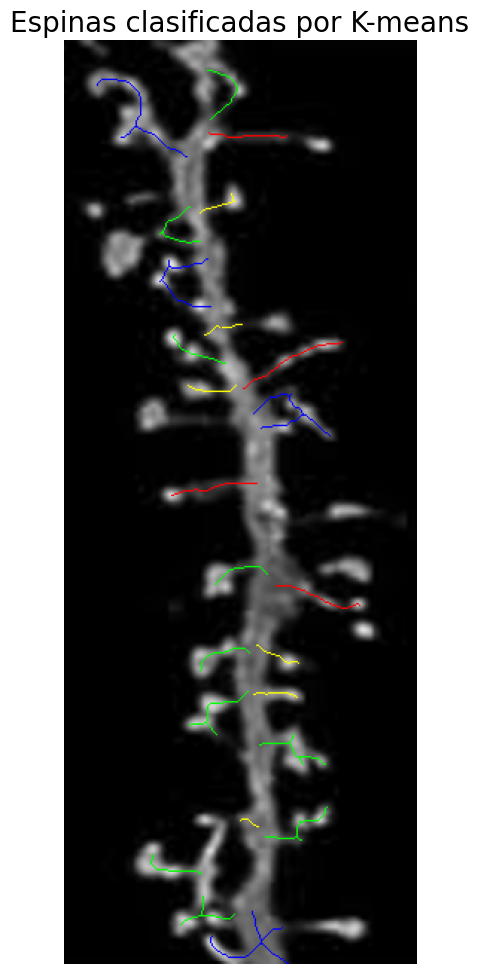

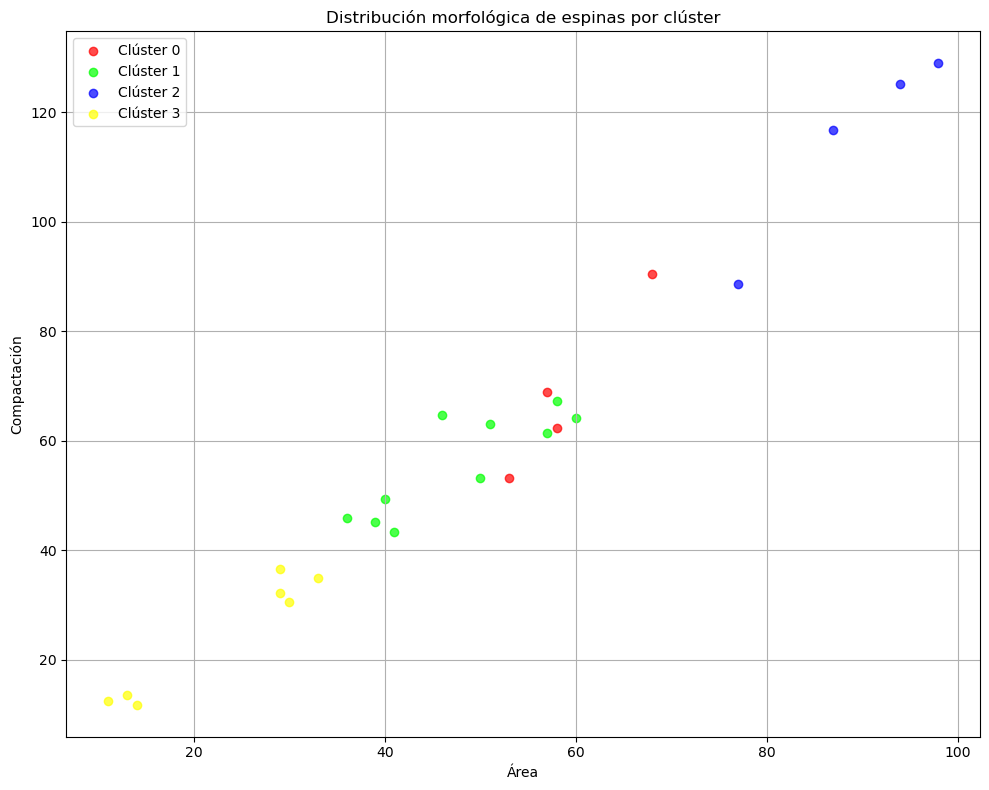

Inercia del modelo: 11.98
Silhouette Score: 0.4883

Resumen de espinas por clúster:
   Cluster  Cantidad  Porcentaje
0        0         4        16.0
1        1        10        40.0
2        2         4        16.0
3        3         7        28.0
Archivo guardado: espinas_clusters.csv


In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# ---------- CONFIGURACION ----------
num_clusters = 4                      # <- Número de grupos para K-means
output_csv = "espinas_clusters.csv"    # <- Nombre del csv de salida
# -----------------------------------

# Etiquetamos las espinas claras de nuevo
espinas_label_2 = label(espinas_claras)
props = regionprops(espinas_label_2, intensity_image=image)

# Extraemos features para clustering
espinas_info = []
for region in props:
    area = region.area
    major = region.major_axis_length
    minor = region.minor_axis_length
    aspect = major / minor if minor > 0 else 0
    perimetro = region.perimeter
    compactacion = (perimetro ** 2) / area if area > 0 else 0

    espinas_info.append({
        "ID": region.label,
        "Área": area,
        "Relación_aspecto": aspect,
        "Compactación": compactacion,
        "Coordenadas": region.coords
    })

df = pd.DataFrame(espinas_info)

# Clustering con K-means
features = df[['Área', 'Relación_aspecto', 'Compactación']]
X = StandardScaler().fit_transform(features)
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

# Creamos un nuevo overlay para poder ver el coloreado por cluster
overlay = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
colores = [(255,0,0), (0,255,0), (0,0,255), (255,255,0), (0,255,255), (255,0,255)]  # hasta 6 clusters

for idx, row in df.iterrows():
    cluster_id = int(row['Cluster'])
    coords = row['Coordenadas']
    color = colores[cluster_id % len(colores)]
    for y, x in coords:
        y, x = int(y), int(x)
        if 0 <= y < overlay.shape[0] and 0 <= x < overlay.shape[1]:
            overlay[y, x] = color

# Mostramos los resultados
plt.figure(figsize=(16, 12))
plt.imshow(overlay)
plt.title("Espinas clasificadas por K-means", fontsize=20)
plt.axis('off')
plt.show()

# Gráfico de dispersión con colores coherentes al overlay
# Convertir los colores BGR de OpenCV a RGB para matplotlib
colores_rgb = [(b/255, g/255, r/255) for (b, g, r) in colores]  # BGR → RGB


plt.figure(figsize=(10, 8))
for cluster_id in range(num_clusters):
    cluster_data = df[df['Cluster'] == cluster_id]
    plt.scatter(cluster_data['Área'], cluster_data['Compactación'],
                label=f"Clúster {cluster_id}",
                alpha=0.7,
                color=colores_rgb[cluster_id % len(colores_rgb)])
plt.xlabel("Área")
plt.ylabel("Compactación")
plt.title("Distribución morfológica de espinas por clúster")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Métricas de calidad del clustering
inertia = kmeans.inertia_
sil_score = silhouette_score(X, df['Cluster'])
print(f"Inercia del modelo: {inertia:.2f}")
print(f"Silhouette Score: {sil_score:.4f}")

# Resumen por clúster
resumen = df['Cluster'].value_counts().sort_index().reset_index()
resumen.columns = ['Cluster', 'Cantidad']
resumen['Porcentaje'] = 100 * resumen['Cantidad'] / resumen['Cantidad'].sum()
print("\nResumen de espinas por clúster:")
print(resumen)

# Exportamos un CSV con resultados
df.drop(columns=["Coordenadas"]).to_csv(output_csv, index=False)
print(f"Archivo guardado: {output_csv}")



Estadísticas por clúster (media y desviación):


Área           Relación_aspecto           Compactación  \
              mean       std             mean       std         mean   
Cluster                                                                
0        59.000000  6.377042        16.797809  5.774652    68.711406   
1        47.800000  8.689713         3.779476  1.851535    55.727455   
2        89.000000  9.201449         1.993242  0.832896   114.832876   
3        22.714286  9.534399         8.788014  2.671240    24.554004   

                    
               std  
Cluster             
0        15.867778  
1         9.320976  
2        18.249212  
3        11.374314

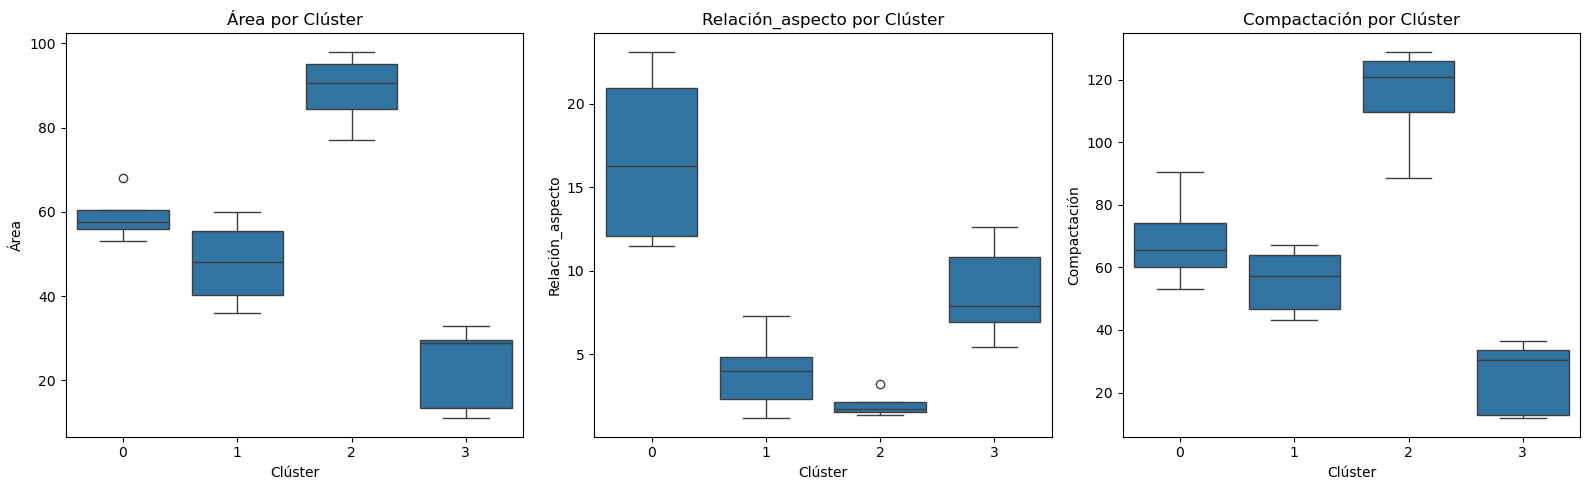

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el archivo CSV generado previamente
csv_path = "espinas_clusters.csv"  # Cambia el nombre si usaste otro
df = pd.read_csv(csv_path)


# Estadísticas generales por clúster
print("\nEstadísticas por clúster (media y desviación):")
estadisticas = df.groupby("Cluster")[['Área', 'Relación_aspecto', 'Compactación']].agg(['mean', 'std'])
display(estadisticas)


# Visualización: boxplots para comparar variables entre clústers
plt.figure(figsize=(16, 5))
for i, feature in enumerate(['Área', 'Relación_aspecto', 'Compactación']):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(data=df, x='Cluster', y=feature)
    plt.title(f"{feature} por Clúster")
    plt.xlabel("Clúster")
    plt.ylabel(feature)
plt.tight_layout()
plt.show()